In [1]:
!pip install -q facenet_pytorch

Preparing dataset of LBP-processed frames...


Processing fake videos: 100%|██████████| 1000/1000 [1:32:59<00:00,  5.58s/it]
/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Dataset prepared. Train: 25592, Val: 6399, Test: 7998


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


Starting training for xception model...


Epoch 1/30: 100%|██████████| 800/800 [03:55<00:00,  3.40it/s]


Epoch 1/30, Train Loss: 0.2325, Train Acc: 89.82%, Val Loss: 0.1088, Val Acc: 96.05%
Validation accuracy improved! Saving best model to ./model_checkpoints_lbp/best_model_xception.pth


Epoch 2/30: 100%|██████████| 800/800 [03:54<00:00,  3.41it/s]


Epoch 2/30, Train Loss: 0.0432, Train Acc: 98.54%, Val Loss: 0.1186, Val Acc: 95.45%
Validation accuracy did not improve. Counter: 1/5


Epoch 3/30: 100%|██████████| 800/800 [03:54<00:00,  3.41it/s]


Epoch 3/30, Train Loss: 0.0238, Train Acc: 99.18%, Val Loss: 0.0872, Val Acc: 96.86%
Validation accuracy improved! Saving best model to ./model_checkpoints_lbp/best_model_xception.pth


Epoch 4/30: 100%|██████████| 800/800 [03:54<00:00,  3.41it/s]


Epoch 4/30, Train Loss: 0.0170, Train Acc: 99.41%, Val Loss: 0.1128, Val Acc: 96.02%
Validation accuracy did not improve. Counter: 1/5


Epoch 5/30: 100%|██████████| 800/800 [03:54<00:00,  3.41it/s]


Epoch 5/30, Train Loss: 0.0140, Train Acc: 99.54%, Val Loss: 0.0930, Val Acc: 97.11%
Validation accuracy improved! Saving best model to ./model_checkpoints_lbp/best_model_xception.pth


Epoch 6/30: 100%|██████████| 800/800 [03:54<00:00,  3.41it/s]


Epoch 6/30, Train Loss: 0.0119, Train Acc: 99.62%, Val Loss: 0.0858, Val Acc: 97.52%
Validation accuracy improved! Saving best model to ./model_checkpoints_lbp/best_model_xception.pth


Epoch 8/30: 100%|██████████| 800/800 [03:54<00:00,  3.41it/s]


Epoch 8/30, Train Loss: 0.0107, Train Acc: 99.63%, Val Loss: 0.1025, Val Acc: 97.47%
Validation accuracy did not improve. Counter: 2/5


Epoch 9/30: 100%|██████████| 800/800 [03:54<00:00,  3.41it/s]


Epoch 9/30, Train Loss: 0.0105, Train Acc: 99.68%, Val Loss: 0.0804, Val Acc: 97.37%
Validation accuracy did not improve. Counter: 3/5


Epoch 10/30: 100%|██████████| 800/800 [03:54<00:00,  3.40it/s]


Epoch 10/30, Train Loss: 0.0112, Train Acc: 99.61%, Val Loss: 0.1184, Val Acc: 96.45%
Validation accuracy did not improve. Counter: 4/5


Epoch 11/30: 100%|██████████| 800/800 [03:54<00:00,  3.40it/s]


Epoch 11/30, Train Loss: 0.0078, Train Acc: 99.74%, Val Loss: 0.1057, Val Acc: 97.09%
Validation accuracy did not improve. Counter: 5/5
Early stopping triggered.

--- Training finished ---


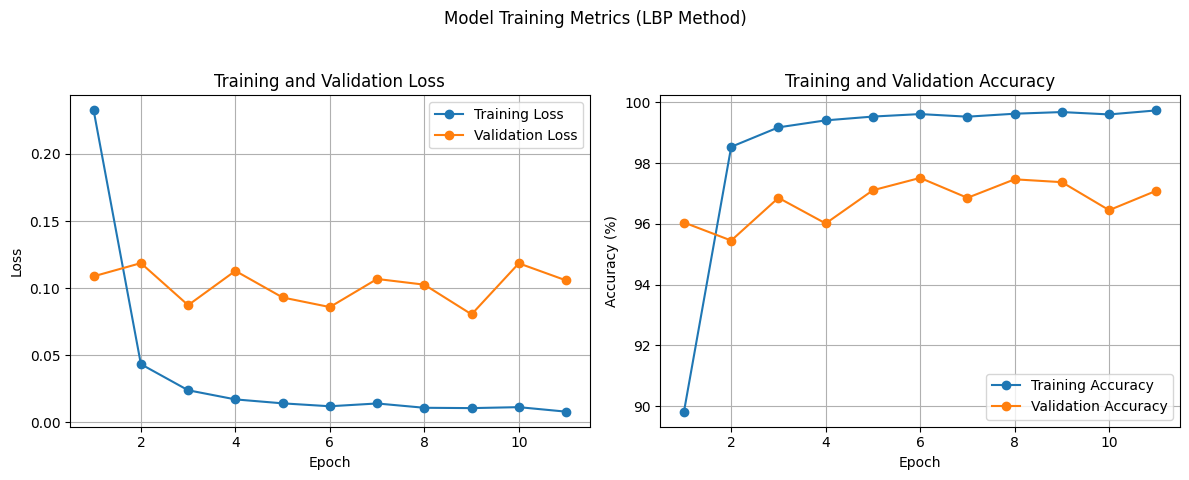

Metrics plot saved to training_metrics_lbp.png

Loading best model from ./model_checkpoints_lbp/best_model_xception.pth for final evaluation...


Evaluating on Test Set: 100%|██████████| 250/250 [00:20<00:00, 12.48it/s]



--- Test Set Evaluation ---
              precision    recall  f1-score   support

        REAL       0.98      0.97      0.97      4000
        FAKE       0.97      0.98      0.97      3998

    accuracy                           0.97      7998
   macro avg       0.97      0.97      0.97      7998
weighted avg       0.97      0.97      0.97      7998



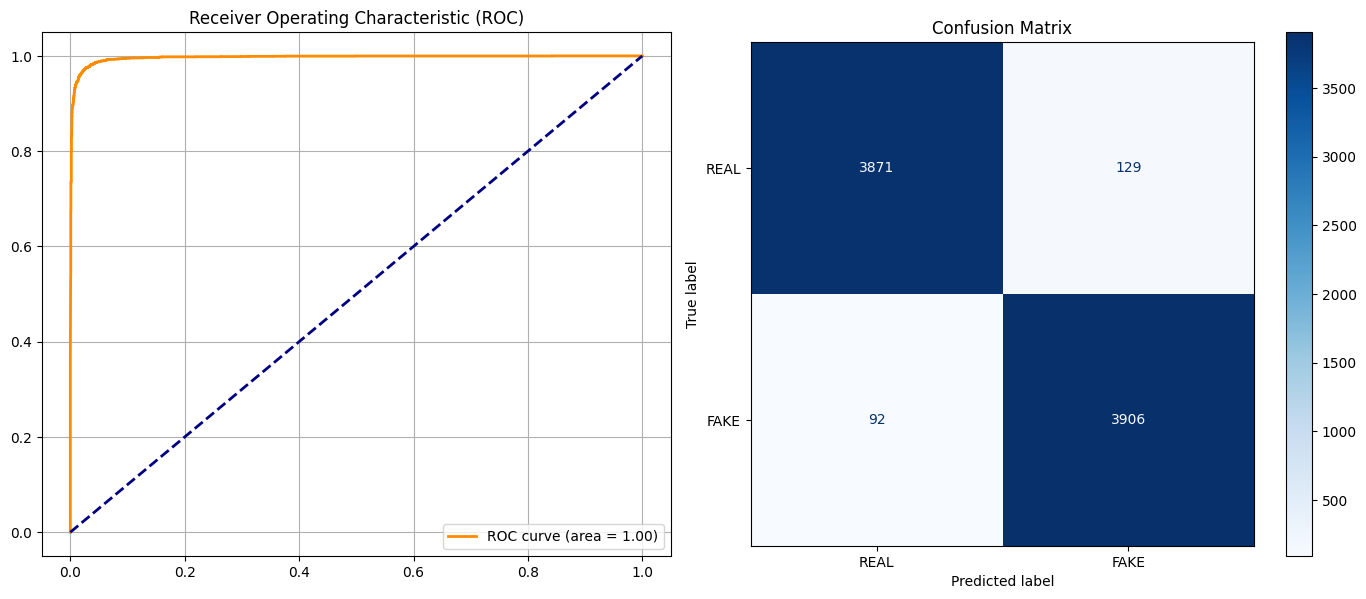

Test evaluation plots saved to test_evaluation_results_lbp.png


In [ ]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy

# --- New Dependencies ---
# You need to install them:
# pip install facenet-pytorch
# pip install scikit-image
# pip install timm
from facenet_pytorch import MTCNN
from skimage.feature import local_binary_pattern
import timm # PyTorch Image Models library for Xception

# --- Configuration ---
CONFIG = {
    "real_data_path": "/kaggle/input/ff-c23/FaceForensics++_C23/original",
    "fake_data_path": "/kaggle/input/ff-c23/FaceForensics++_C23/Deepfakes",
    "max_videos_per_class": 1000, 
    "frames_per_video": 20,       
    "image_size": 224,
    "batch_size": 32,            
    "epochs": 30,
    "learning_rate": 1e-4,
    "seed": 42,
    "model_name": "xception",    # recommended by the paper
    "model_save_path": "./model_checkpoints_lbp",
    "early_stopping_patience": 5,
    "weight_decay": 1e-5,
}

# Set seed for reproducibility
torch.manual_seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Step 1: Data Preparation with MTCNN and LBP ---

# Initialize MTCNN for face detection
mtcnn = MTCNN(keep_all=False, post_process=False, min_face_size=20, device=device)

def apply_gaussian_and_lbp(image):
    """
    Applies Gaussian blur and LBP to a single PIL image.
    This is the core preprocessing step from the paper.
    """
    # Convert PIL image to numpy array (grayscale for LBP)
    img_np_gray = np.array(image.convert('L'))
    
    # 1. Apply Gaussian Filter
    img_blur = cv2.GaussianBlur(img_np_gray, (3, 3), 0)
    
    # 2. Apply Local Binary Pattern (LBP)
    # These parameters are common defaults for LBP
    n_points = 24
    radius = 3
    lbp = local_binary_pattern(img_blur, n_points, radius, method='uniform')
    
    # Normalize LBP to be in 0-255 range
    lbp = (lbp / np.max(lbp) * 255).astype(np.uint8)
    
    # Convert grayscale LBP to a 3-channel image to match CNN input expectations
    lbp_rgb = cv2.cvtColor(lbp, cv2.COLOR_GRAY2RGB)
    
    # Convert back to PIL Image for torchvision transforms
    return Image.fromarray(lbp_rgb)


def prepare_frames_dataset(config):
    """
    Loads videos, extracts frames, detects faces, applies LBP,
    and creates a dataset of individual images.
    """
    print("Preparing dataset of LBP-processed frames...")
    all_images = []
    all_labels = []

    def process_videos(video_paths, label, desc):
        for video_path in tqdm(video_paths, desc=desc):
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened(): continue

            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            frame_indices = np.linspace(0, frame_count - 1, config["frames_per_video"], dtype=int)

            for i in frame_indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, i)
                ret, frame = cap.read()
                if not ret: continue

                frame_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                face_tensor = mtcnn(frame_pil)

                if face_tensor is not None:
                    face_pil = transforms.ToPILImage()(face_tensor)
                    # Apply the paper's preprocessing pipeline
                    lbp_image = apply_gaussian_and_lbp(face_pil)
                    all_images.append(lbp_image)
                    all_labels.append(label)
            cap.release()

    real_videos = [os.path.join(config["real_data_path"], f) for f in os.listdir(config["real_data_path"])][:config["max_videos_per_class"]]
    process_videos(real_videos, 0, "Processing real videos") # 0 for REAL

    fake_videos = [os.path.join(config["fake_data_path"], f) for f in os.listdir(config["fake_data_path"])][:config["max_videos_per_class"]]
    process_videos(fake_videos, 1, "Processing fake videos") # 1 for FAKE

    # Split into train, validation, and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        all_images, all_labels, test_size=0.20, random_state=config["seed"], stratify=all_labels
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.20, random_state=config["seed"], stratify=y_train_val
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# --- Step 2: Create a PyTorch Dataset for Images ---
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return self.transform(image), torch.tensor(label, dtype=torch.long)

# --- Step 3: Define the Model---
def get_model(model_name, num_classes=2):
    """
    Loads a pre-trained model from timm and adjusts the classifier.
    """
    # Using timm library to easily get the Xception model
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
    return model

# --- Evaluation and Plotting Functions ---
def plot_and_save_metrics(train_loss, val_loss, train_acc, val_acc, save_path="training_metrics_lbp.png"):
    # This function remains the same as before
    epochs_range = range(1, len(train_loss) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_loss, 'o-', label='Training Loss')
    plt.plot(epochs_range, val_loss, 'o-', label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_acc, 'o-', label='Training Accuracy')
    plt.plot(epochs_range, val_acc, 'o-', label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.suptitle('Model Training Metrics (LBP Method)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(save_path)
    plt.show()
    print(f"Metrics plot saved to {save_path}")

def evaluate_on_test_set(model, test_loader, device):
    # This function remains the same as before
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            _, predicted = torch.max(outputs.data, 1)
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    print("\n--- Test Set Evaluation ---")
    print(classification_report(all_labels, all_preds, target_names=['REAL', 'FAKE']))
    
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['REAL', 'FAKE'])
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig("test_evaluation_results_lbp.png")
    plt.show()
    print("Test evaluation plots saved to test_evaluation_results_lbp.png")

# --- Main Execution ---
if __name__ == "__main__":
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_frames_dataset(CONFIG)
    print(f"Dataset prepared. Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

    # Standard transforms for the LBP images
    data_transforms = transforms.Compose([
        transforms.Resize((CONFIG["image_size"], CONFIG["image_size"])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # Normalize for grayscale-like images
    ])

    train_dataset = ImageDataset(X_train, y_train, data_transforms)
    val_dataset = ImageDataset(X_val, y_val, data_transforms)
    test_dataset = ImageDataset(X_test, y_test, data_transforms)

    train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=2, pin_memory=True)
    
    model = get_model(CONFIG["model_name"]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=CONFIG["weight_decay"])
    
    model_save_dir = CONFIG["model_save_path"]
    os.makedirs(model_save_dir, exist_ok=True)
    best_model_path = os.path.join(model_save_dir, f"best_model_{CONFIG['model_name']}.pth")

    train_loss_history, val_loss_history, train_acc_history, val_acc_history = [], [], [], []
    best_val_accuracy = 0
    epochs_no_improve = 0
    
    print(f"Starting training for {CONFIG['model_name']} model...")
    for epoch in range(CONFIG["epochs"]):
        model.train()
        running_loss, train_correct, train_total = 0.0, 0, 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * train_correct / train_total
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_train_acc)
        
        model.eval()
        val_correct, val_total, running_val_loss = 0, 0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss = criterion(outputs, labels)
                running_val_loss += val_loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        epoch_val_acc = 100 * val_correct / val_total
        epoch_val_loss = running_val_loss / len(val_loader)
        val_acc_history.append(epoch_val_acc)
        val_loss_history.append(epoch_val_loss)
        
        print(f"Epoch {epoch+1}/{CONFIG['epochs']}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")

        if epoch_val_acc > best_val_accuracy:
            best_val_accuracy = epoch_val_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"Validation accuracy improved! Saving best model to {best_model_path}")
        else:
            epochs_no_improve += 1
            print(f"Validation accuracy did not improve. Counter: {epochs_no_improve}/{CONFIG['early_stopping_patience']}")

        if epochs_no_improve >= CONFIG['early_stopping_patience']:
            print("Early stopping triggered.")
            break

    print("\n--- Training finished ---")
    plot_and_save_metrics(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    
    print(f"\nLoading best model from {best_model_path} for final evaluation...")
    model.load_state_dict(torch.load(best_model_path))
    evaluate_on_test_set(model, test_loader, device)
